In [1]:
3# importing the necessary libraries:
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import leidenalg
import scipy.sparse as sp
import math
import gseapy as gp

In [27]:
wt = sc.read("../scripts/wt.h5ad")

In [28]:
print(wt.obs["leiden"])

Wound_56_1        2
Wound_67_1        2
Wound_413_1       2
Wound_420_1       2
Wound_2366_1      2
                 ..
Cell_9906906_5    2
Cell_9909534_5    2
Cell_9911428_5    2
Cell_9913730_5    3
Cell_9916084_5    3
Name: leiden, Length: 8372, dtype: category
Categories (2, object): ['2', '3']


In [29]:
leiden3 = wt[wt.obs["leiden"] == "3", :].copy()

In [30]:
# Create a unified column to hold our comparison group
leiden3.obs["blgroup"] = "other"

# Mark wound blood (from time_point)
leiden3.obs.loc[leiden3.obs["time_point"] == "Wound_blood", "blgroup"] = "Wound_blood"

# Mark tumour blood (from batch)
leiden3.obs.loc[leiden3.obs["batch"] == "Tumour_blood", "blgroup"] = "Tumour_blood"


In [31]:
print(leiden3.obs["blgroup"].value_counts())

blgroup
other           3086
Wound_blood       12
Tumour_blood       3
Name: count, dtype: int64


In [36]:
leiden3.obs["blgroup"].unique()

array(['other', 'Wound_blood', 'Tumour_blood'], dtype=object)

In [55]:
# Set seed for reproducibility
np.random.seed(42)

# --- 1. Get all cell IDs labelled as 'other'
other_ids = leiden3.obs_names[leiden3.obs["blgroup"] == "other"]

# --- 2. Randomly pick 15 of them
sampled_other_ids = np.random.choice(other_ids, size=15, replace=False)

# --- 3. Subset those cells if you want a new AnnData
other_sampled = leiden3[sampled_other_ids, :].copy()

# Check how many you got
print(other_sampled.n_obs)
print(other_sampled.obs["blgroup"].value_counts())


15
blgroup
other    15
Name: count, dtype: int64


In [56]:
print(other_sampled.obs_names)

Index(['Cell_5470943_2', 'Cell_4435268_4', 'Cell_9152731_2', 'Cell_4730518_0',
       'Cell_6082257_2', 'Cell_9751763_0', 'Cell_2218018_0', 'Cell_7104800_2',
       'Cell_10324640_5', 'Cell_298452_0', 'Cell_11946323_0', 'Cell_5907864_0',
       'Cell_10184458_2', 'Cell_302280_2', 'Cell_13008470_0'],
      dtype='object')


In [57]:
other_sampled_ids = list(other_sampled.obs_names)

In [7]:
neu = sc.read("../data/merged_neu_with_blob.h5ad")

In [8]:
print(neu.obs["blob"])

Wound_56_1          Effector
Wound_65_1        Blood-like
Wound_67_1          Effector
Wound_413_1         Effector
Wound_420_1         Effector
                     ...    
Cell_9914160_5      Effector
Cell_9914204_5      Effector
Cell_9914519_5      Effector
Cell_9914949_5      Effector
Cell_9916084_5      Effector
Name: blob, Length: 34572, dtype: category
Categories (2, object): ['Blood-like', 'Effector']


In [10]:
Blood = neu[neu.obs["blob"] == "Blood-like", :].copy()

In [11]:
# Fix the random seed for reproducibility
np.random.seed(42)

# Randomly choose 15 cell indices
sample_idx = np.random.choice(Blood.obs_names, size=15, replace=False)

# Create the downsampled Blood group
Blood_sampled = Blood[sample_idx, :].copy()

In [37]:
Blood_sampled.obs["blob"].unique()

['Blood-like']
Categories (1, object): ['Blood-like']

In [38]:
# Get cell IDs (obs_names) for each group
wound_blood_ids = leiden3.obs_names[leiden3.obs["blgroup"] == "Wound_blood"]
tumour_blood_ids = leiden3.obs_names[leiden3.obs["blgroup"] == "Tumour_blood"]

# Print or inspect
print("Wound_blood cell IDs:", wound_blood_ids)
print("Tumour_blood cell IDs:", tumour_blood_ids)


Wound_blood cell IDs: Index(['Wound_7843518_2', 'Wound_8236233_2', 'Wound_13939001_2',
       'Wound_22798449_2', 'Wound_24130994_2', 'Wound_32459851_2',
       'Wound_32504262_2', 'Wound_35939393_2', 'Wound_37071210_2',
       'Wound_41393991_2', 'Wound_52910200_2', 'Wound_55431633_2'],
      dtype='object')
Tumour_blood cell IDs: Index(['Cell_12413986_3', 'Cell_3987132_3', 'Cell_4430657_3'], dtype='object')


In [39]:
print(Blood_sampled.obs_names)

Index(['Cell_10800046_2', 'Cell_9458010_4', 'Cell_9146202_4', 'Cell_892062_0',
       'Cell_5776157_2', 'Cell_2217607_2', 'Wound_40305808_2',
       'Wound_56065405_2', 'Wound_22425356_2', 'Cell_2827023_2',
       'Wound_40440373_2', 'Wound_53088846_2', 'Wound_28955622_2',
       'Cell_11524632_4', 'Cell_4879123_3'],
      dtype='object')


create one merged list for reference and check

In [40]:
UT_blood_ids = list(wound_blood_ids) + list(tumour_blood_ids)
Blood_sampled_ids = list(Blood_sampled.obs_names)

In [41]:
print(UT_blood_ids)

['Wound_7843518_2', 'Wound_8236233_2', 'Wound_13939001_2', 'Wound_22798449_2', 'Wound_24130994_2', 'Wound_32459851_2', 'Wound_32504262_2', 'Wound_35939393_2', 'Wound_37071210_2', 'Wound_41393991_2', 'Wound_52910200_2', 'Wound_55431633_2', 'Cell_12413986_3', 'Cell_3987132_3', 'Cell_4430657_3']


In [42]:
print(Blood_sampled_ids)

['Cell_10800046_2', 'Cell_9458010_4', 'Cell_9146202_4', 'Cell_892062_0', 'Cell_5776157_2', 'Cell_2217607_2', 'Wound_40305808_2', 'Wound_56065405_2', 'Wound_22425356_2', 'Cell_2827023_2', 'Wound_40440373_2', 'Wound_53088846_2', 'Wound_28955622_2', 'Cell_11524632_4', 'Cell_4879123_3']


Create a new AnnData with just those cells from bloods in the leiden 3 and blood-like cells

In [43]:
selected_ids = UT_blood_ids + Blood_sampled_ids
subset = neu[selected_ids, :].copy()

In [47]:
subset.n_obs
subset.obs_names

Index(['Wound_7843518_2', 'Wound_8236233_2', 'Wound_13939001_2',
       'Wound_22798449_2', 'Wound_24130994_2', 'Wound_32459851_2',
       'Wound_32504262_2', 'Wound_35939393_2', 'Wound_37071210_2',
       'Wound_41393991_2', 'Wound_52910200_2', 'Wound_55431633_2',
       'Cell_12413986_3', 'Cell_3987132_3', 'Cell_4430657_3',
       'Cell_10800046_2', 'Cell_9458010_4', 'Cell_9146202_4', 'Cell_892062_0',
       'Cell_5776157_2', 'Cell_2217607_2', 'Wound_40305808_2',
       'Wound_56065405_2', 'Wound_22425356_2', 'Cell_2827023_2',
       'Wound_40440373_2', 'Wound_53088846_2', 'Wound_28955622_2',
       'Cell_11524632_4', 'Cell_4879123_3'],
      dtype='object')

Add a comparison column

In [48]:
subset.obs["comparison_group"] = np.where(
    subset.obs_names.isin(UT_blood_ids),
    "UT_blood",
    "blood"
)

In [49]:
subset.obs["comparison_group"].value_counts()

comparison_group
UT_blood    15
blood       15
Name: count, dtype: int64

In [50]:
subset

AnnData object with n_obs × n_vars = 30 × 27429
    obs: 'time_point', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'leiden', 'cell_type', 'sample', 'batch', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'log10_total_counts', 'S_score', 'G2M_score', 'phase', 'Leiden_start_cluster_0.1_opt_sc', 'Leiden_start_cluster_0.4_opt_sc', 'Leiden_start_cluster_0.7_opt_sc', 'Leiden_start_cluster_1_opt_sc', 'Leiden_start_cluster_1.3_opt_sc', 'Leiden_start_cluster_1.5_opt_sc', 'Leiden_start_cluster_1.8_opt_sc', 'Leiden_start_cluster_2.5_opt_sc', 'blob', 'comparison_group'

In [51]:
sc.tl.rank_genes_groups(
    subset,
    groupby="comparison_group",
    groups=["UT_blood"],
    reference="blood",
    method="wilcoxon",
    layer="log1p"
)


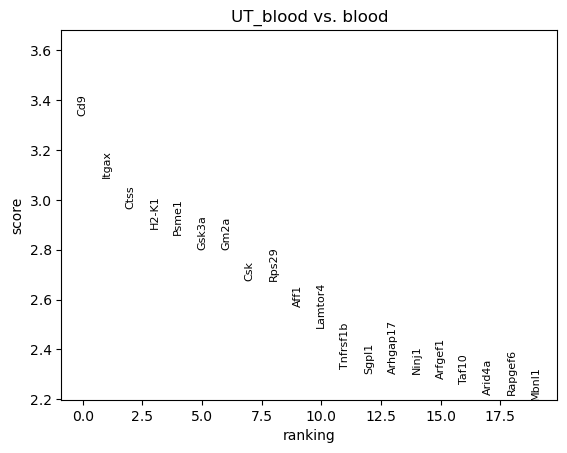

In [52]:
sc.pl.rank_genes_groups(subset, n_genes=20, sharey=False)


categories: UT_blood, blood
var_group_labels: UT_blood


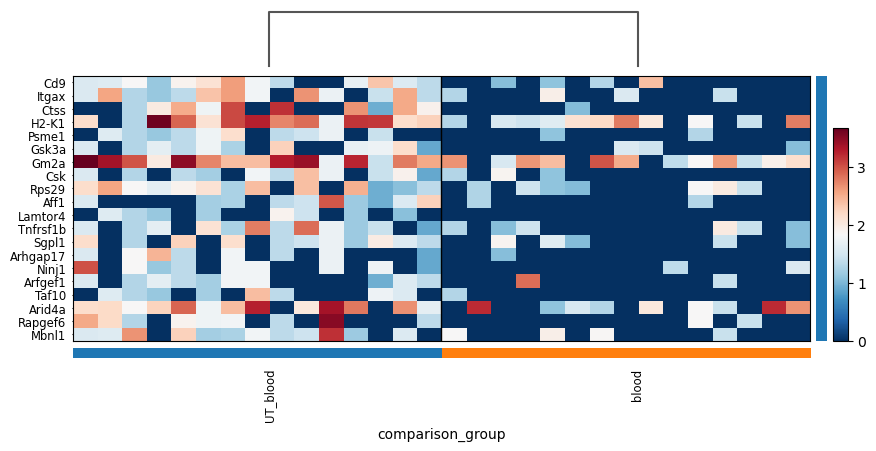

In [53]:
sc.pl.rank_genes_groups_heatmap(
    subset,
    groupby="comparison_group",
    n_genes=20,             # top 20 genes per group
    use_raw=False,          # use layer or X
    layer="log1p",          # specify your log-normalized layer
    swap_axes=True,         # puts genes on y-axis, groups on x-axis
    cmap="RdBu_r",          # diverging red–blue color map
    show=True
)


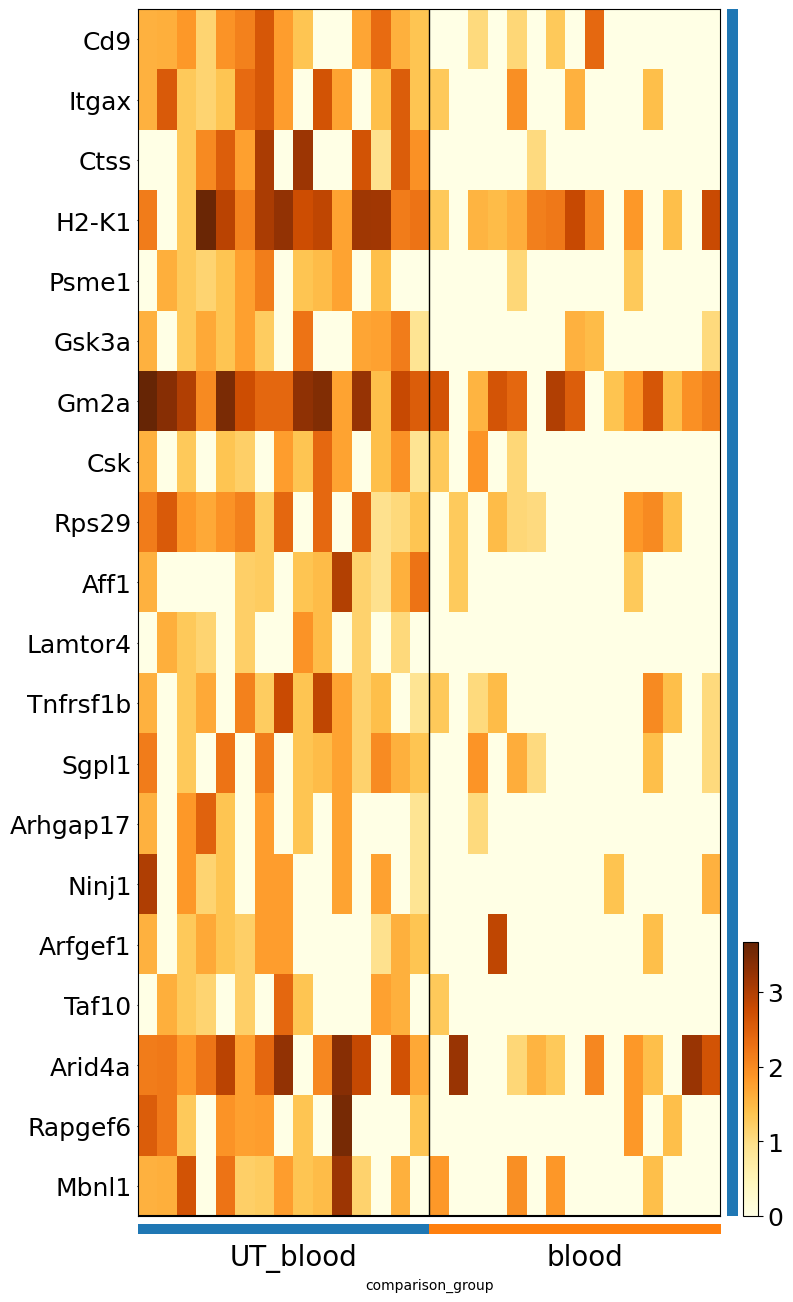

In [54]:
sc.pl.rank_genes_groups_heatmap(
    subset,
    groupby="comparison_group",
    n_genes=20,   
    swap_axes=True,
    cmap="YlOrBr",
    dendrogram=False,
    show_gene_labels=True,
    use_raw=False,
    layer="log1p",
    figsize=(8, 16),
    show=False
)


fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=20)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=18)
    if ax.get_xlabel() == "groups":
        ax.set_xlabel("")
axes = fig.get_axes()
axes[0].axhline(19.5, color="black")
#axes[0].axvline(6350.5, color="black", linewidth=0.7)
plt.tight_layout()
plt.show()


In [64]:
deg_df = sc.get.rank_genes_groups_df(subset, group=None)
deg_df.to_csv("DEG_UTblood_vs_Blood.csv", index=False)

Create a new AnnData with just those cells from bloods in the leiden 3 and random other cells in leiden 3

In [58]:
chosen_ids = UT_blood_ids + other_sampled_ids
chosen = neu[chosen_ids, :].copy()

In [59]:
chosen.n_obs
chosen.obs_names

Index(['Wound_7843518_2', 'Wound_8236233_2', 'Wound_13939001_2',
       'Wound_22798449_2', 'Wound_24130994_2', 'Wound_32459851_2',
       'Wound_32504262_2', 'Wound_35939393_2', 'Wound_37071210_2',
       'Wound_41393991_2', 'Wound_52910200_2', 'Wound_55431633_2',
       'Cell_12413986_3', 'Cell_3987132_3', 'Cell_4430657_3', 'Cell_5470943_2',
       'Cell_4435268_4', 'Cell_9152731_2', 'Cell_4730518_0', 'Cell_6082257_2',
       'Cell_9751763_0', 'Cell_2218018_0', 'Cell_7104800_2', 'Cell_10324640_5',
       'Cell_298452_0', 'Cell_11946323_0', 'Cell_5907864_0', 'Cell_10184458_2',
       'Cell_302280_2', 'Cell_13008470_0'],
      dtype='object')

Add a comparison column for chosen

In [60]:
chosen.obs["comparison_group2"] = np.where(
    chosen.obs_names.isin(UT_blood_ids),
    "UT_blood",
    "other"
)

In [61]:
chosen.obs["comparison_group2"].value_counts()

comparison_group2
UT_blood    15
other       15
Name: count, dtype: int64

In [62]:
chosen

AnnData object with n_obs × n_vars = 30 × 27429
    obs: 'time_point', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'leiden', 'cell_type', 'sample', 'batch', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'log10_total_counts', 'S_score', 'G2M_score', 'phase', 'Leiden_start_cluster_0.1_opt_sc', 'Leiden_start_cluster_0.4_opt_sc', 'Leiden_start_cluster_0.7_opt_sc', 'Leiden_start_cluster_1_opt_sc', 'Leiden_start_cluster_1.3_opt_sc', 'Leiden_start_cluster_1.5_opt_sc', 'Leiden_start_cluster_1.8_opt_sc', 'Leiden_start_cluster_2.5_opt_sc', 'blob', 'comparison_group2

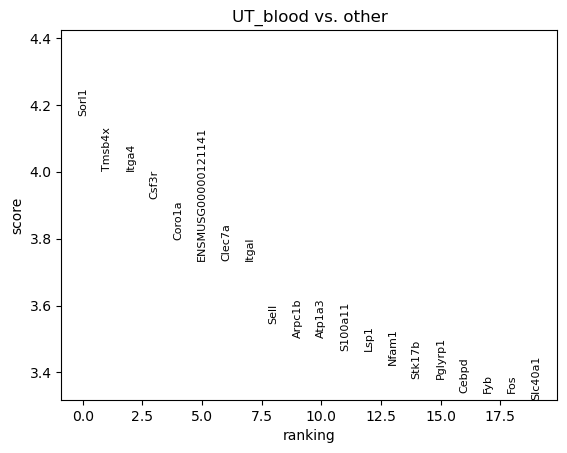

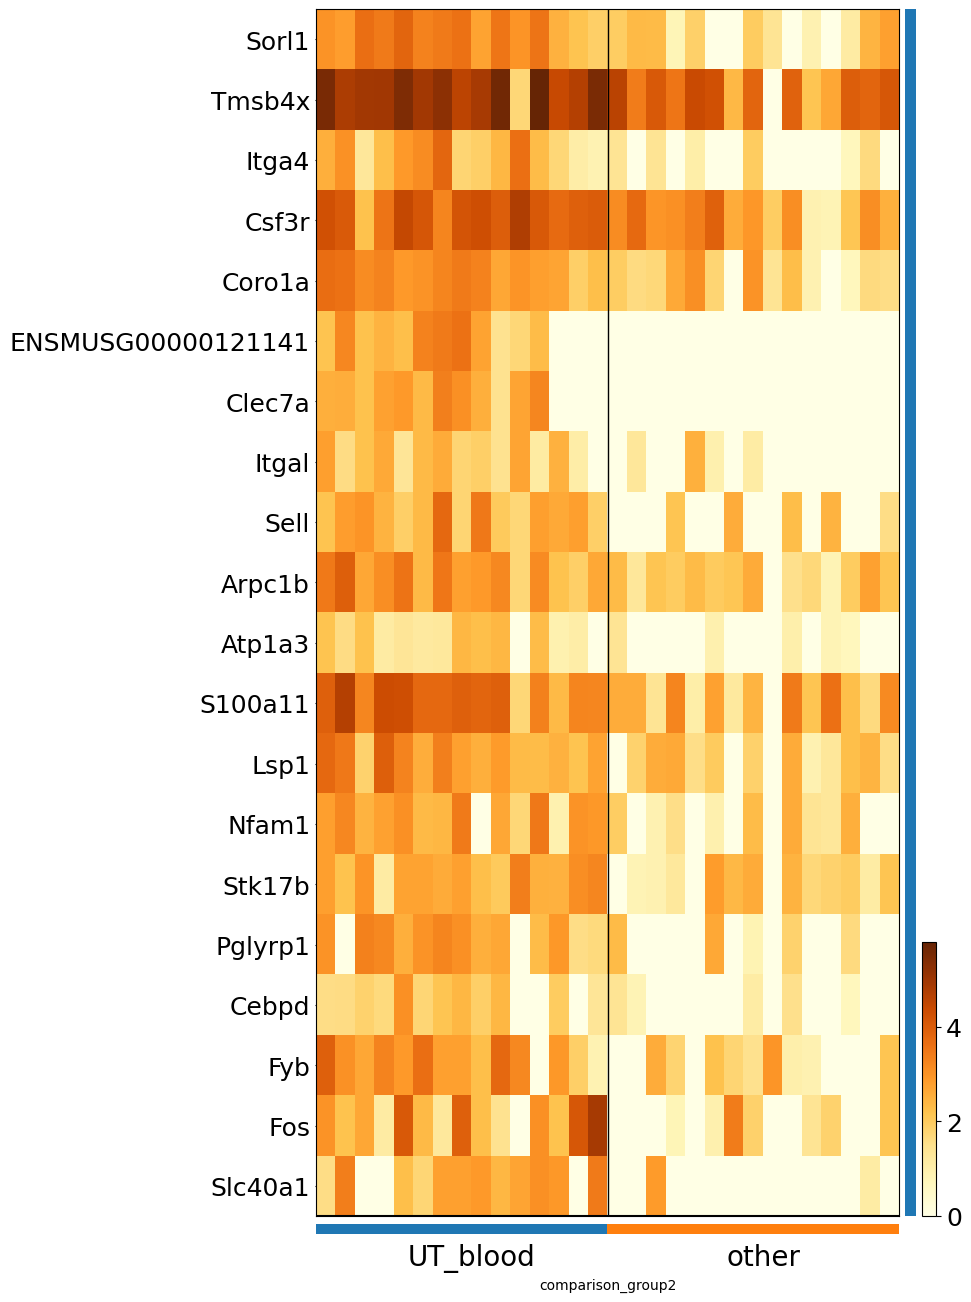

In [63]:
sc.tl.rank_genes_groups(
    chosen,
    groupby="comparison_group2",
    groups=["UT_blood"],
    reference="other",
    method="wilcoxon",
    layer="log1p"
)
sc.pl.rank_genes_groups(chosen, n_genes=20, sharey=False)

sc.pl.rank_genes_groups_heatmap(
    chosen,
    groupby="comparison_group2",
    n_genes=20,   
    swap_axes=True,
    cmap="YlOrBr",
    dendrogram=False,
    show_gene_labels=True,
    use_raw=False,
    layer="log1p",
    figsize=(8, 16),
    show=False
)


fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=20)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=18)
    if ax.get_xlabel() == "groups":
        ax.set_xlabel("")
axes = fig.get_axes()
axes[0].axhline(19.5, color="black")
#axes[0].axvline(6350.5, color="black", linewidth=0.7)
plt.tight_layout()
plt.show()


In [65]:
deg_df2 = sc.get.rank_genes_groups_df(chosen, group=None)
deg_df2.to_csv("DEG_UTblood_vs_other.csv", index=False)